# Escolhendo modelos

Dentre uma variedade gigante de modelos, vamos focar em 3: K-Nearest Neighbours (KNN), Suppport Vector Machines (SVM) e Long-short Term Memory Neural Networks (LSTM). As duas primeiras possuem diversas implementações no SkLearn, enquanto que a terceira pode ser usada com o PyTorch. 

Primeiro, vamos criar alguns dados dummy para podermos entender e visualizar o funcionamento dos algoritmos. Abaixo, temos um conjunto de dados com 500 amostras, duas dimensões (características) e três centros (classes).

Aumentando o desvio padrão (**cluster_std**) permite que os clusters fiquem mais esparsos, gerando intersecções entre elas. Vamos usar apenas duas características (**n_feats**) para podermos visualizar o problema.

In [1]:
import numpy as np
import pandas as pd
import gensim
from context import fakenews
from fakenews import preprocess as pre

In [2]:
from sklearn.datasets import make_blobs

dummyfeats, dummylbl = make_blobs(n_features=2, n_samples=2000, centers=3, cluster_std=3)

Os dados gerados serão diferentes a cada execução, mas **cluster_std=3** já é o suficiente para garantir alguma interseção entre as amostras. Acima disso já comça a virar bagunça!

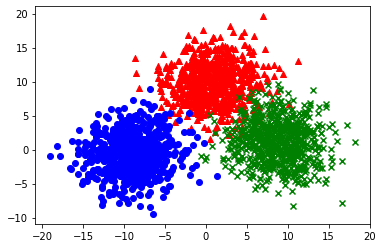

In [3]:
import matplotlib.pyplot as plt

def plot_data(data, lbls):
    c1 = data[lbls == 0]
    c2 = data[lbls == 1]
    c3 = data[lbls == 2]
    plt.scatter(c1[:, 0], c1[:, 1], marker='^', color='red')
    plt.scatter(c2[:, 0], c2[:, 1], marker='o', color='blue')
    plt.scatter(c3[:, 0], c3[:, 1], marker='x', color='green')
plot_data(dummyfeats, dummylbl)

Agora, precisamos dividir os dados em treino e teste. Poderíamos também adicionar um terceiro subconjunto **validação**, mas futuramente usaremos validação cruzada. Lembrando que, a **validação cruzada** permite simular o conjunto de validação quando não temos dados suficientes.

Vamos usar, novamente, o SkLearn para isso. O método abaixo possui várias customizações permitindo sua aplicação em diferentes cenários. Abaixo, a separação mais simples consiste em apenas escolher o tamanho do conjunto de teste (**test_size**)

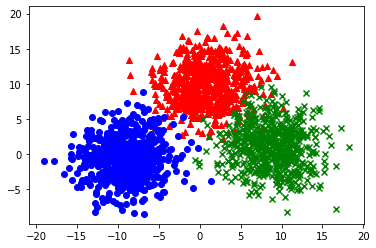

In [4]:
from sklearn.model_selection import train_test_split

dummysplits = train_test_split(dummyfeats, dummylbl, test_size=0.1)
dummy_ftrain, dummy_ftest, dummylbl_train, dummylbl_test = dummysplits

plot_data(dummy_ftrain, dummylbl_train)

Em alguns casos, principalmente em problemas de identificação, pode ser necessário garantir que todas as classes estejam presentes em ambos os conjuntos. Podemos usar a separação estratificada (**stratify**), mantendo as proporções dos dados de acordo com alguma característica da base.

In [5]:
dummysplits = train_test_split(dummyfeats, dummylbl, test_size=0.3, stratify=dummylbl)
dummy_ftrain, dummy_ftest, dummylbl_train, dummylbl_test = dummysplits

Por fim, para evitar que seus experimentos sejam tendenciados por ter escolhido um ponto muito no espaço de busca (ou muito ruim) também podemos embaralhar as amostras (**shuffle**). No entanto, acaba sendo desnecessário quando usamos validação cruzada.

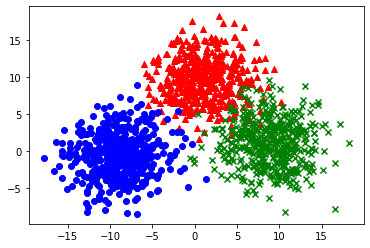

In [6]:
dummysplits = train_test_split(dummyfeats, dummylbl, test_size=0.3, stratify=dummylbl, shuffle=True)
dummy_ftrain, dummy_ftest, dummylbl_train, dummylbl_test = dummysplits

plot_data(dummy_ftrain, dummylbl_train)

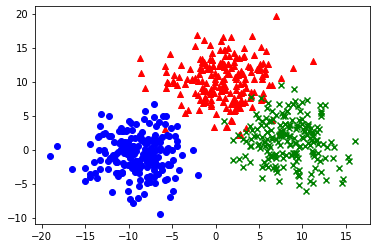

In [7]:
plot_data(dummy_ftest, dummylbl_test)

Com os dados devidamente separados, podemos aplicar ao nosso modelo para treinamento e teste. Vamos usar o KNN para exemplificar o procedimento, e mais na frente fazemos o mesmo de forma resumida para o SVM e o LSTM. Na maioria dos casos, os modelos do SkLearn fazem o treinamento a partir do método **fit**, o teste com o **predict**, os dois com o **fit_predict**, ou também podemos usar o **score** para calcular alguma métrica sobre a predição. 

In [8]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(dummy_ftrain, dummylbl_train)
knn.score(dummy_ftest, dummylbl_test)

0.9733333333333334

Com esses métodos, temos um modelo decente para classificar nossos dados. Mas ainda podemos ir além, pois o knn está usando apenas valores padrões. Embora sejam valores comuns, **não são os melhores!**. Vejamos quantos parâmetros o modelo posssui

In [9]:
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

Temos um total de 8 parâmetros que podem ser ajustados no nosso modelo! Dentre eles, **p**, **n_neighbors** e **weights** podem afetar nossa performance. Vamos aumentar a quantidade de vizinhos e ver qual o efeito disso

In [10]:
knn.set_params(n_neighbors=7)
knn.score(dummy_ftest, dummylbl_test)

0.9783333333333334

E que tal reduzir pra 1?

In [11]:
knn.set_params(n_neighbors=1)
knn.score(dummy_ftest, dummylbl_test)

0.9616666666666667

E pra 200?

In [12]:
knn.set_params(n_neighbors=200)
knn.score(dummy_ftest, dummylbl_test)

0.9816666666666667

Otimizar os parâmetros assim é bastante trabalhoso e aumenta substancialmente a probabilidade de errarmos ou esquecer alguma coisa no caminho. Para evitar isso, podemos automatizar nossa busca pelo modelo _"ótimo"_ para o nosso problema. Vamos usar uma forma mais simples e ordenada para otmização dos parâmetros: **Grid Search**.

Isso é literalmente criar uma malha (ou uma matriz, se preferir) onde podemos ver cada coluna como valores de parâmetros a serem otimizados, sendo assim as linhas as combinações entre esses parâmetros. Por exemplo, para o knn

In [14]:
from sklearn.model_selection import GridSearchCV

pgrid = [{'n_neighbors': [5, 10, 15, 20], 'p': [1, 2, 3]}]

estimator = KNeighborsClassifier()
gsearch = GridSearchCV(estimator, pgrid, cv=3)
gsearch.fit(dummy_ftrain, dummylbl_train)
cv_results = pd.DataFrame(gsearch.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_p,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001134,0.000492,0.020061,0.002672,5,1,"{'n_neighbors': 5, 'p': 1}",0.965739,0.957173,0.965665,0.962859,0.004021,11
1,0.000721,0.000043,0.017692,0.000415,5,2,"{'n_neighbors': 5, 'p': 2}",0.967880,0.957173,0.965665,0.963573,0.004615,9
2,0.000757,0.000039,0.019521,0.000564,5,3,"{'n_neighbors': 5, 'p': 3}",0.965739,0.957173,0.965665,0.962859,0.004021,11
3,0.000673,0.000026,0.017584,0.000312,10,1,"{'n_neighbors': 10, 'p': 1}",0.970021,0.957173,0.963519,0.963571,0.005245,10
4,0.000737,0.000058,0.017588,0.000183,10,2,"{'n_neighbors': 10, 'p': 2}",0.978587,0.963597,0.963519,0.968568,0.007085,7
5,0.000689,0.000021,0.019958,0.000106,10,3,"{'n_neighbors': 10, 'p': 3}",0.980728,0.961456,0.965665,0.969283,0.008273,6
6,0.000686,0.000036,0.017823,0.000244,15,1,"{'n_neighbors': 15, 'p': 1}",0.972163,0.963597,0.967811,0.967857,0.003497,8
7,0.000739,0.000028,0.017705,0.000027,15,2,"{'n_neighbors': 15, 'p': 2}",0.980728,0.961456,0.969957,0.970714,0.007886,3
8,0.000690,0.000043,0.020095,0.000157,15,3,"{'n_neighbors': 15, 'p': 3}",0.980728,0.963597,0.972103,0.972143,0.006994,1
9,0.000693,0.000009,0.018320,0.000298,20,1,"{'n_neighbors': 20, 'p': 1}",0.974304,0.963597,0.974249,0.970717,0.005034,2


O **pgrid** é justamente a matriz de combinações que queremos testar. Note que usamos o parâmetro **cv**, ele permite especificar qual tipo de validação cruzada queremos usar. No exemplo acima, optei por usar uma validação cruzada 3 estratificada.

Em seguida, visualizamos os resultados como um DataFrame. Mas o cv_results é um dicionário com várias informações sobre as execuções! Também podemos ver qual foi a melhor configuração, uma instância do melhor classficador,

In [15]:
print(f'Best conf: {gsearch.best_params_}')
gsearch.best_estimator_

Best conf: {'n_neighbors': 15, 'p': 3}


KNeighborsClassifier(n_neighbors=15, p=3)

Agora, com o nosso classificador bombado podemos usá-lo no conjunto de teste!

In [16]:
knn = gsearch.best_estimator_
knn.score(dummy_ftest, dummylbl_test)

0.98

Vamos visualizar os resultados de forma mais detalhada usando uma matriz de confusão

[[194   0   6]
 [  1 200   0]
 [  5   0 194]]


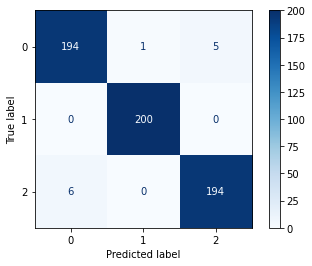

In [17]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

preds = knn.predict(dummy_ftest)
print(confusion_matrix(preds, dummylbl_test))
plot_confusion_matrix(knn, dummy_ftest, dummylbl_test, cmap='Blues')

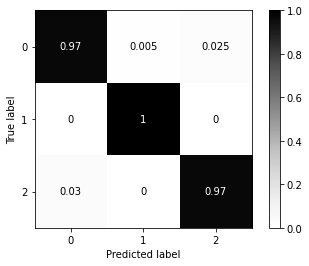

In [18]:
plot_confusion_matrix(knn, dummy_ftest, dummylbl_test, cmap='Greys', normalize='true')

Então, temos um modelo ótimo? Provavelmente não, a forma como o GS funciona nos permite verificar onde provavelmente está o nosso valor ótimo e daí podemos realizar uma nova busca dentro desse intervalo. Entretanto isso é muito custoso e entramos num looping infinito! Por exemplo, podemos verificar a acarácia do modelo de acordo com variações em `k`

In [19]:
manh = cv_results[cv_results['param_p'] == 1]
eucl = cv_results[cv_results['param_p'] == 2]
mink = cv_results[cv_results['param_p'] == 3]
mink

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_p,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
2,0.000757,0.000039,0.019521,0.000564,5,3,"{'n_neighbors': 5, 'p': 3}",0.965739,0.957173,0.965665,0.962859,0.004021,11
5,0.000689,0.000021,0.019958,0.000106,10,3,"{'n_neighbors': 10, 'p': 3}",0.980728,0.961456,0.965665,0.969283,0.008273,6
8,0.000690,0.000043,0.020095,0.000157,15,3,"{'n_neighbors': 15, 'p': 3}",0.980728,0.963597,0.972103,0.972143,0.006994,1
11,0.000755,0.000043,0.020840,0.000407,20,3,"{'n_neighbors': 20, 'p': 3}",0.974304,0.963597,0.972103,0.970002,0.004617,5


(0.5, 1.0)

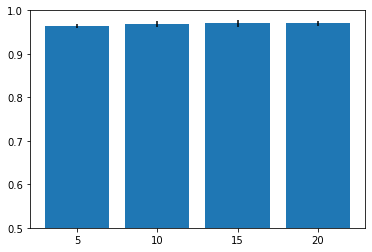

In [20]:
plt.bar(np.arange(4), eucl['mean_test_score'], tick_label=eucl['param_n_neighbors'], yerr=eucl['std_test_score'])
plt.ylim(.5, 1)

Como não há muita variação, isso indica que podemos aumentar o espaço de busca para o valor de `k`. Onde caso houve uma queda seguida de subida, indicaria o intervalo no qual uma nova busca pode ser realizada.

## Adicionano outros modelos para comparação

In [21]:
from sklearn.svm import SVC

svm = SVC()
pgrid = [{'kernel': ['rbf', 'sigmoid'], 'C':[0.01, 0.1, 1], 'gamma':[0.001, 0.01]},
         {'kernel': ['poly'], 'C':[0.01, 0.1, 1], 'gamma':[0.001, 0.01], 'degree':[2, 3]},]
gs_svm = GridSearchCV(svm, pgrid, cv=3)
gs_svm.fit(dummy_ftrain, dummylbl_train)
results = pd.DataFrame(gs_svm.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,param_degree,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.021492,0.000675,0.006062,0.000054,0.01,0.001,rbf,NaN,"{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}",0.972163,0.877944,0.954936,0.935014,0.040963,14
1,0.029923,0.000075,0.009438,0.000080,0.01,0.001,sigmoid,NaN,"{'C': 0.01, 'gamma': 0.001, 'kernel': 'sigmoid'}",0.976445,0.471092,0.768240,0.738593,0.207372,16
2,0.013509,0.000299,0.004421,0.000159,0.01,0.01,rbf,NaN,"{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}",0.978587,0.959315,0.974249,0.970717,0.008255,1
3,0.022322,0.000252,0.010957,0.000156,0.01,0.01,sigmoid,NaN,"{'C': 0.01, 'gamma': 0.01, 'kernel': 'sigmoid'}",0.978587,0.955032,0.969957,0.967859,0.009730,8
4,0.008331,0.000046,0.003378,0.000069,0.1,0.001,rbf,NaN,"{'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}",0.976445,0.959315,0.974249,0.970003,0.007611,4


In [22]:
bestsvm = gs_svm.best_estimator_
gs_svm.best_params_

{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}

In [23]:
bestsvm.score(dummy_ftest, dummylbl_test)

0.9816666666666667

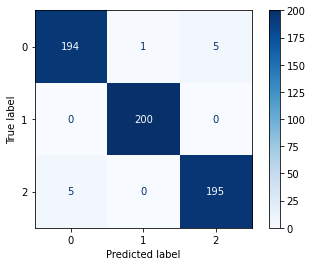

In [24]:
plot_confusion_matrix(bestsvm, dummy_ftest, dummylbl_test, cmap='Blues')

In [25]:
from sklearn.metrics import f1_score, make_scorer


scorer = make_scorer(f1_score, average='macro')
f1gs_svm = GridSearchCV(svm, pgrid, cv=3, scoring=scorer)
f1gs_svm.fit(dummy_ftrain, dummylbl_train)
results = pd.DataFrame(f1gs_svm.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,param_degree,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.021774,0.000853,0.006849,0.000076,0.01,0.001,rbf,NaN,"{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}",0.972139,0.875393,0.954731,0.934088,0.042107,14
1,0.030318,0.000273,0.010313,0.000102,0.01,0.001,sigmoid,NaN,"{'C': 0.01, 'gamma': 0.001, 'kernel': 'sigmoid'}",0.976413,0.381596,0.759877,0.705962,0.245807,16
2,0.013716,0.000393,0.005321,0.000013,0.01,0.01,rbf,NaN,"{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}",0.978598,0.959378,0.974213,0.970730,0.008224,1
3,0.022586,0.000539,0.011834,0.000244,0.01,0.01,sigmoid,NaN,"{'C': 0.01, 'gamma': 0.01, 'kernel': 'sigmoid'}",0.978664,0.955225,0.969880,0.967923,0.009668,8
4,0.008480,0.000012,0.004110,0.000156,0.1,0.001,rbf,NaN,"{'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}",0.976482,0.959378,0.974213,0.970024,0.007585,5


In [26]:
bestf1_svm = f1gs_svm.best_estimator_
f1gs_svm.best_params_

{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}

In [27]:
preds = bestf1_svm.predict(dummy_ftest)
f1_score(preds, dummylbl_test, average='macro')

0.9816457707027335

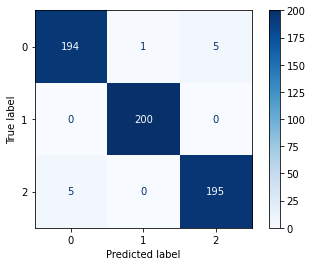

In [30]:
plot_confusion_matrix(bestf1_svm, dummy_ftest, dummylbl_test, cmap='Blues')

In [31]:
rbfresults = results[results['param_kernel'] == 'sigmoid']
rbfresults_gamma = rbfresults[rbfresults['param_gamma'] == 0.01]
rbfresults_gamma

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,param_degree,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
3,0.022586,0.000539,0.011834,0.000244,0.01,0.01,sigmoid,NaN,"{'C': 0.01, 'gamma': 0.01, 'kernel': 'sigmoid'}",0.978664,0.955225,0.969880,0.967923,0.009668,8
7,0.009237,0.000395,0.006095,0.000057,0.1,0.01,sigmoid,NaN,"{'C': 0.1, 'gamma': 0.01, 'kernel': 'sigmoid'}",0.974304,0.963694,0.972079,0.970025,0.004568,4
11,0.004640,0.000476,0.003372,0.000228,1,0.01,sigmoid,NaN,"{'C': 1, 'gamma': 0.01, 'kernel': 'sigmoid'}",0.974345,0.955007,0.965576,0.964976,0.007906,10


(0.5, 1.0)

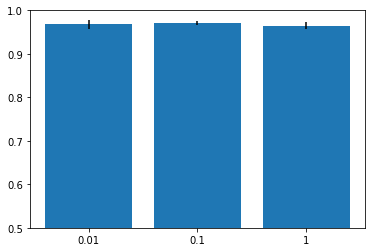

In [32]:
plt.bar(np.arange(3), 
        rbfresults_gamma['mean_test_score'],
        tick_label=rbfresults_gamma['param_C'],
        yerr=rbfresults_gamma['std_test_score'])

plt.ylim(.5, 1)

Nesse caso podemos visualizar que ao aumentar `C` de 0.1 para 1, com $\gamma = 0.01$, a acurácia reduz consecutivamente. Isso indica que o ótimo deve estar entre os valores 0.01 e 0.1. Dessa forma, caso queiramos otimizar ainda mais o modelo, poderíamos expandir o intervalo de $C$ para $C\in[0.01, 0.03, 0.05, 0.07, 0.09, 0.1]$ e repetir o processo quantas vezes for necessário.

### Randomized Search

Também podemos usar outras técnicas de otimização como a busca **aleatória** e em **árvore**. Ao contrário  do GS, a busca aleatória usa distribuições ao invés de valores fixos. O SkLearn não disponibiliza uma classe para busca em árvore, mas tendo em vista que isso é nada mais que um backpropagation com prunning, podemos usar de outras bibliotecas.

Para gerar as distribuições, o módulo ´stats´ do scipy oferece: exponencial, uniforme, gamma e outras.

In [33]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon

rnd_space = [{'kernel': ['rbf'], 'C':expon(scale=10), 'gamma':expon(scale=.1)}]
rnds_svm = RandomizedSearchCV(SVC(), rnd_space, cv=3)
rnds_svm.fit(dummy_ftrain, dummylbl_train)
results = pd.DataFrame(rnds_svm.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.006788,0.000329,0.001467,0.000106,8.29993,0.0712005,rbf,"{'C': 8.299932689059942, 'gamma': 0.0712004593...",0.970021,0.961456,0.969957,0.967145,0.004023,8
1,0.003670,0.000576,0.002059,0.000296,2.88833,0.000782161,rbf,"{'C': 2.8883341788338024, 'gamma': 0.000782160...",0.976445,0.961456,0.967811,0.968571,0.006143,3
2,0.016581,0.001980,0.002293,0.000053,2.0047,0.152347,rbf,"{'C': 2.004699617620465, 'gamma': 0.1523468426...",0.972163,0.959315,0.972103,0.967860,0.006043,4
3,0.003294,0.000572,0.000812,0.000059,29.1359,0.0138005,rbf,"{'C': 29.13585520621269, 'gamma': 0.0138005393...",0.976445,0.959315,0.969957,0.968572,0.007062,2
4,0.002008,0.000127,0.000866,0.000022,8.18786,0.0031188,rbf,"{'C': 8.187861953758299, 'gamma': 0.0031187969...",0.976445,0.957173,0.969957,0.967859,0.008006,5


In [34]:
bestrnd_svm = rnds_svm.best_estimator_
rnds_svm.best_params_

{'C': 14.135246599261473, 'gamma': 0.017463399964873488, 'kernel': 'rbf'}

In [35]:
bestrnd_svm.score(dummy_ftest, dummylbl_test)

0.975

Note que agora os parâmetros estão numa escala bem diferente comparadas ao GridSearch! Outra parte importante sobre o randomized é a quantidade de amostras, por padrão são usadas 10 amostras das distribuições, mas podemos alterar isso usando com o `n_iter=30`

In [36]:
rnd_space = [{'kernel': ['rbf'], 'C':expon(scale=10), 'gamma':expon(scale=.1)}]
rnds_svm = RandomizedSearchCV(SVC(), rnd_space, cv=3, n_iter=30)
rnds_svm.fit(dummy_ftrain, dummylbl_train)
results = pd.DataFrame(rnds_svm.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.010961,0.002325,0.001764,0.000163,4.79278,0.104214,rbf,"{'C': 4.792776755365131, 'gamma': 0.1042140432...",0.970021,0.959315,0.969957,0.966431,0.005032,26
1,0.009611,0.000425,0.001547,0.000096,3.88261,0.0989378,rbf,"{'C': 3.882607053779126, 'gamma': 0.0989377511...",0.970021,0.961456,0.969957,0.967145,0.004023,21
2,0.010588,0.000433,0.001743,0.000046,3.09474,0.107879,rbf,"{'C': 3.0947394955577785, 'gamma': 0.107879408...",0.972163,0.961456,0.969957,0.967859,0.004616,17
3,0.004758,0.000083,0.001213,0.000108,2.95475,0.055206,rbf,"{'C': 2.9547523271025544, 'gamma': 0.055205981...",0.974304,0.963597,0.967811,0.968571,0.004404,15
4,0.021756,0.000861,0.002702,0.000059,0.752796,0.214064,rbf,"{'C': 0.7527959624405325, 'gamma': 0.214063551...",0.974304,0.961456,0.972103,0.969288,0.005610,7


In [37]:
bestrnd_svm = rnds_svm.best_estimator_
rnds_svm.best_params_

{'C': 0.20958714341977913, 'gamma': 0.03102405948814005, 'kernel': 'rbf'}

In [38]:
bestrnd_svm.score(dummy_ftest, dummylbl_test)

0.9783333333333334

### Aplicando as fakenews

Vamos carregar os dados e aplicar os passos do preprocessamento novamente (sim, eu esqueci de salvar a base). Mas ainda precisamos fazer mais alguns passos antes de aplicar aos modelos.

In [39]:
base = '/home/thalesaguiar/Dev/FakeNews/'
news, labels = pre.run(base + 'data/Fake.csv', base + 'data/True.csv')
print(news[0][:10])

Succesfully read data from:
Fakes: /home/thalesaguiar/Dev/FakeNews/data/Fake.csv
Reals: /home/thalesaguiar/Dev/FakeNews/data/True.csv
Removing rows without text...
Removing publisher information...
Adding class column...
Merging fakes and reals
Merging titles and bodies...
Removing subjects and date...
Tokenizing data...
['donald', 'trump', 'sends', 'embarrassing', 'new', 'year', 'eve', 'message', 'disturbing', 'donald']


In [40]:
pre.truncate_news(news)

Truncating at 869


Vamos novamente, mais uma vez, carregar nosso modelo w2v na memória. Entretanto, o que o w2v modela?

In [41]:
w2v = gensim.models.Word2Vec.load('fakenews-w2v.model')

In [42]:
news[0][:10]

['donald',
 'trump',
 'sends',
 'embarrassing',
 'new',
 'year',
 'eve',
 'message',
 'disturbing',
 'donald']

O w2v está modelando cada palavra, entretanto estamos tentando identificar se o DOCUMENTO (new) é fake ou não. Então, precisamos ajustar as features, ou a forma de predição dos classificadores. No caso das features

In [43]:
splits = train_test_split(news, labels, test_size=0.3, shuffle=True)
news_trn, news_tst, labels_trn, labels_tst = splits

trn_vecs = []
for new in news_trn:
    vecs = w2v.wv[new]
    meanvec = np.mean(vecs, axis=0)
    trn_vecs.append(meanvec)

trn_vecs = np.array(trn_vecs)
    
tst_vecs = []
for new in news_tst:
    vecs = w2v.wv[new]
    meanvec = np.mean(vecs, axis=0)
    tst_vecs.append(meanvec)

tst_vecs = np.array(tst_vecs)

In [44]:
print(f'Training data shape: {trn_vecs.shape}')
print(f'Test data shape: {tst_vecs.shape}')

Training data shape: (30986, 100)
Test data shape: (13281, 100)


In [45]:
models = [KNeighborsClassifier()]
pgrids = [
    {'n_neighbors': [4, 8, 16], 'p': [2, 3]}
]

In [46]:
best_models = []
for model, grid in zip(models, pgrids):
    optimizer = GridSearchCV(model, grid, cv=3)
    optimizer.fit(trn_vecs, labels_trn)
    best_models.append(optimizer.best_estimator_)

best_models

KNeighborsClassifier(n_neighbors=16, p=3)


[KNeighborsClassifier(n_neighbors=16, p=3)]

In [49]:
for model in best_models:
    testacc = model.score(tst_vecs, labels_tst)
    print(testacc)

0.9402153452300278


Quanto a alterar a forma de predição, precisamos expandir os rótulos. Essa expansão adiciona um label para cada palavra onde esse label corresponde ao label do notícia. Desa forma, para o knn, vamos predizer para cada palvra e usar a classe mais frequente como resultado final. Para o SVM, podemos fazer algo semelhante.